<a href="https://colab.research.google.com/github/Deivison-Amorim/ML-AD-Tics4-UFRPE/blob/main/Projeto_Final_Machine_Learning_e_An%C3%A1lise_de_Dados_Vers%C3%A3o_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTAÇÕES UTILIZADAS NO CÓDIGO**

In [ ]:
import numpy as np
import pandas as pd
import re, os

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SimpleRNN 
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**PARÂMETROS IMPORTANTES** 

In [ ]:
epochs = 10 # Quantidade de épocas utilizadas no treinamento
batch_size = 20 # Número de amostras a serem utilizadas a cada época
max_fatures = 5000 # Quantidade de palavras mantidas no vocabulário
embed_dim = 128 # Tamanho de saída da camada Embedding
max_sequence_length = 1000 # Tamanho máximo de todas as sentenças
seed = 7
np.random.seed(seed)


**DEFINIÇÃO DE FUNÇÕES**

In [ ]:
def limpar_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    cleanr = re.compile('<.*?>')
    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')

    return string.strip().lower()


def preparar_dados(data):
    
    data = data[['texto','sentimento']]
    
    data['texto'] = data['texto'].apply(lambda x: limpar_str(x))
    data['texto'] = data['texto'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    
    stop_words = set(stopwords.words('portuguese'))
    texto = []


    for row in data['texto'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        texto.append(no_stop_words)

    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(texto)

    X = tokenizer.texts_to_sequences(texto)  
    X = pad_sequences(X, maxlen=max_sequence_length)
    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['sentimento']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer


def model():
    
    input_shape = (max_sequence_length,)
    model_input = Input(shape=input_shape, name="input", dtype='int32')    

    embedding = Embedding(max_fatures, embed_dim, input_length=max_sequence_length, name="embedding")(model_input)
        
    rnn = SimpleRNN(embed_dim, dropout=0.2, recurrent_dropout=0.2, name="SimpleRNN")(embedding)
        
    model_output = Dense(2, activation='sigmoid', name="sigmoid")(rnn)
    
    model = Model(inputs=model_input, outputs=model_output)
    
    return model

**BASE DA DADOS E MODELO**

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset/Projeto Final - Disciplina Redes Neurais/review_books.xlsx')

print('Data: ', data)

data.texto=data.texto.astype(str)

X_train, X_test, Y_train, Y_test, word_index, tokenizer = preparar_dados(data)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

model = model()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Data:                                                    texto sentimento
0     Concordo com outras avaliações feitas, entre o...        neg
1     Que história chata! Personagens chatos, diálog...        neg
2     A estória podia ter fim no primeiro livro, des...        neg
3     Muito narrativo, não prende atenção, tive apre...        neg
4     Olá, Recebi uma notificação por email que não ...        neg
...                                                 ...        ...
1995  Quando li pela primeira vez, eu tinha 19 anos ...        pos
1996  Um livrinho capaz de fazer as grandes pessoas ...        pos
1997  Livro maravilhoso para crianças pequenas e gra...        pos
1998  Chegou 4 dias antes do prazo de entrega estima...        pos
1999  Sempre fui apaixonada nos filmes de Harry Pott...        pos

[2000 rows x 2 columns]
(1600, 1000) (1600, 2)
(400, 1000) (400, 2)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output 

**TREINAMENTO**

In [ ]:
plot = model.fit(X_train,Y_train,validation_data=(X_test, Y_test),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

Epoch 1/10
80/80 [==============================] - 46s 416ms/step - loss: 0.7206 - accuracy: 0.4925 - val_loss: 0.6884 - val_accuracy: 0.5750
Epoch 2/10
80/80 [==============================] - 33s 411ms/step - loss: 0.6753 - accuracy: 0.6169 - val_loss: 0.6770 - val_accuracy: 0.5975
Epoch 3/10
80/80 [==============================] - 33s 407ms/step - loss: 0.6249 - accuracy: 0.6862 - val_loss: 0.6369 - val_accuracy: 0.6650
Epoch 4/10
80/80 [==============================] - 33s 410ms/step - loss: 0.5299 - accuracy: 0.8006 - val_loss: 0.6485 - val_accuracy: 0.6175
Epoch 5/10
80/80 [==============================] - 33s 407ms/step - loss: 0.3974 - accuracy: 0.8494 - val_loss: 0.6489 - val_accuracy: 0.6875
Epoch 6/10
80/80 [==============================] - 36s 453ms/step - loss: 0.2219 - accuracy: 0.9287 - val_loss: 0.5158 - val_accuracy: 0.7950
Epoch 7/10
80/80 [==============================] - 32s 405ms/step - loss: 0.1258 - accuracy: 0.9681 - val_loss: 0.5702 - val_accuracy: 0.8025

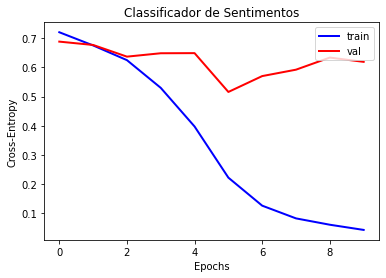

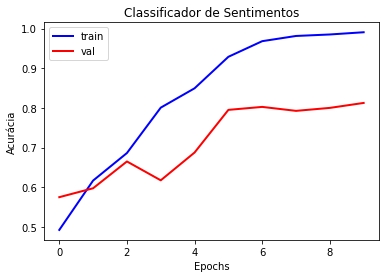

In [ ]:
plt.figure()
plt.plot(plot.history['loss'], lw=2.0, color='b', label='train')
plt.plot(plot.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Classificador de Sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(plot.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(plot.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Classificador de Sentimentos')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='upper left')
plt.show()